In [1]:
import os
import random
os.chdir("..")

import pandas as pd

# Display options
pd.set_option("display.max_rows", 100)  # Show up to 100 rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Expand the display width to prevent line breaks

In [3]:
os.getcwd()

'/Users/youngmincho/Project/DraftingAlpha'

In [2]:
import os
import pandas as pd
import random
import time

# Settings
ADP_FOLDER = "adp"
SEASONAL_STATS_FOLDER = "seasonalstats"
DEFENSIVE_STATS_FOLDER = "defensivestats"
RESULTS_FOLDER = "results"
NUMBER_OF_TRIALS = 3
NUM_MANAGERS = 12
NUM_ROUNDS = 16

# Position limits and requirements
POSITION_LIMITS = {"QB": 4, "RB": 8, "WR": 8, "TE": 3, "K": 3, "DST": 3}
REQUIRED_POSITIONS = {"QB": 1, "K": 1, "DST": 1, "RB": 2, "WR": 2, "TE": 1}

# Weighted probabilities for player selection
ROUND_1_3_WEIGHTS = [0.64, 0.20, 0.10, 0.05, 0.01]  # Rounds 1–3
ROUND_4_16_WEIGHTS = [0.50, 0.10, 0.10, 0.10, 0.10, 0.10]  # Rounds 4–16


# Utility: Load files
def load_file(folder, filename):
    file_path = os.path.join(folder, filename)
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    raise FileNotFoundError(f"File {filename} not found in folder {folder}")


# Load ADP file
def load_adp_file():
    year = random.choice([2018, 2019, 2020, 2021, 2022, 2023])
    file_name = f"{year}ADP.csv"
    adp_df = load_file(ADP_FOLDER, file_name)
    adp_df['year'] = year  
    return adp_df


# Load stats
def load_seasonal_stats(year):
    return load_file(SEASONAL_STATS_FOLDER, f"player_stats_{year}.csv")


def load_defensive_stats(year):
    return load_file(DEFENSIVE_STATS_FOLDER, f"seasonal_defensive_stats_{year}.csv")


# Merge stats into ADP
def merge_stats(adp_df, seasonal_stats_df, defensive_stats_df):
    adp_df = adp_df.merge(
        seasonal_stats_df[["player_id", "fppr"]], on="player_id", how="left"
    )
    defensive_stats_df = defensive_stats_df.rename(columns={"pa_team": "player_id", "fpts": "def_fpts"})
    adp_df = adp_df.merge(
        defensive_stats_df[["player_id", "def_fpts"]], on="player_id", how="left"
    )
    adp_df["fpts"] = adp_df.apply(
        lambda row: row["def_fpts"] if row["POSITION"] == "DST" else row["fppr"], axis=1
    )
    return adp_df


# Select player with weighted probabilities
def select_player_with_weights(players, weights):
    """
    Randomly select a player based on weighted probabilities.
    """
    return random.choices(players.to_dict("records"), weights=weights[:len(players)], k=1)[0]



adp_df = load_adp_file()
year = adp_df['year'].iloc[0]
seasonal_stats_df = load_seasonal_stats(year)
defensive_stats_df = load_defensive_stats(year)
adp_df = merge_stats(adp_df, seasonal_stats_df, defensive_stats_df)

# Sort players by FPPRAVG
adp_df = adp_df.sort_values(by="FPPRAVG").reset_index(drop=True)


# Initialize draft setup
draft_order = list(range(1, NUM_MANAGERS + 1))
random.shuffle(draft_order)
results = []
pick_order = 1

# Track positions
required_positions = {f"Team_{i}": REQUIRED_POSITIONS.copy() for i in range(1, NUM_MANAGERS + 1)}
team_counts = {f"Team_{i}": REQUIRED_POSITIONS.copy() for i in range(1, NUM_MANAGERS + 1)}


In [7]:
def load_adp_file():
        year = random.choice([2018, 2019, 2020, 2021, 2022, 2023])
        file_name = f"{year}ADP.csv"
        adp_df = load_file(ADP_FOLDER, file_name)
        adp_df["year"] = year
        return adp_df

adp_df = load_file('adp', '')
year = adp_df["year"].iloc[0]
seasonal_stats_df, defensive_stats_df = load_stats(year)
adp_df = merge_stats(adp_df, seasonal_stats_df, defensive_stats_df)
adp_df = adp_df.sort_values(by="FPPRAVG").reset_index(drop=True)

NameError: name 'file_name' is not defined

## QLearning

In [21]:
import os
import pandas as pd
import random
import numpy as np

# Settings
ADP_FOLDER = "adp"
SEASONAL_STATS_FOLDER = "seasonalstats"
DEFENSIVE_STATS_FOLDER = "defensivestats"
NUM_ROUNDS = 16
NUM_MANAGERS = 12
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 1.0  # Initial exploration rate
EPSILON_MIN = 0.01  # Minimum exploration rate
EPSILON_DECAY = 0.995  # Decay factor for epsilon after each trial


# Utility Functions
def load_file(folder, filename):
    file_path = os.path.join(folder, filename)
    return pd.read_csv(file_path)

def load_adp_file():
    year = random.choice([2018, 2019, 2020, 2021, 2022, 2023])
    file_name = f"{year}ADP.csv"
    adp_df = load_file(ADP_FOLDER, file_name)
    adp_df["year"] = year
    return adp_df

def load_stats(year):
    seasonal_stats_df = load_file(SEASONAL_STATS_FOLDER, f"player_stats_{year}.csv")
    defensive_stats_df = load_file(DEFENSIVE_STATS_FOLDER, f"seasonal_defensive_stats_{year}.csv")
    return seasonal_stats_df, defensive_stats_df

def merge_stats(adp_df, seasonal_stats_df, defensive_stats_df):
    adp_df = adp_df.merge(seasonal_stats_df[["player_id", "fppr"]], on="player_id", how="left")
    defensive_stats_df = defensive_stats_df.rename(columns={"pa_team": "player_id", "fpts": "def_fpts"})
    adp_df = adp_df.merge(defensive_stats_df[["player_id", "def_fpts"]], on="player_id", how="left")
    adp_df["fpts"] = adp_df.apply(lambda row: row["def_fpts"] if row["POSITION"] == "DST" else row["fppr"], axis=1)
    adp_df["fpts"] = adp_df["fpts"].round(2)
    return adp_df

# Q-Learning Draft Simulation
def q_learning_draft(trials=10):
    all_results = []

    for trial in range(trials):
        adp_df = load_adp_file()
        year = adp_df["year"].iloc[0]
        seasonal_stats_df, defensive_stats_df = load_stats(year)
        adp_df = merge_stats(adp_df, seasonal_stats_df, defensive_stats_df)
        adp_df = adp_df.sort_values(by="FPPRAVG").reset_index(drop=True)

        q_table = {}
        team_roster = []
        pick_order = 1

        # Simulate rounds
        for round_num in range(1, NUM_ROUNDS + 1):
            available_players = adp_df.to_dict("records")  # Include all player info

            for manager in range(1, NUM_MANAGERS + 1):
                if manager == 1:  # Team 1 uses Q-learning
                    # State: current roster (player positions and IDs)
                    state = tuple(sorted([p["player_id"] for p in team_roster]))

                    # Select action
                    if random.uniform(0, 1) < EPSILON:
                        selected_player = random.choice(available_players)
                    else:
                        selected_player = max(
                            available_players, 
                            key=lambda p: q_table.get((state, p["player_id"]), 0)
                        )

                    # Reward: fantasy points with ADP penalty
                    reward = selected_player["fpts"] - 0.01 * selected_player["FPPRAVG"]  # Small penalty for ADP rank

                    # Update Q-value
                    action = selected_player["player_id"]
                    next_state = tuple(sorted([p["player_id"] for p in team_roster] + [action]))
                    next_available_players = [p for p in available_players if p["player_id"] != action]

                    future_q = max([q_table.get((next_state, p["player_id"]), 0) for p in next_available_players], default=0)
                    q_table[(state, action)] = q_table.get((state, action), 0) + ALPHA * (
                        reward + GAMMA * future_q - q_table.get((state, action), 0)
                    )

                    # Add player to team roster
                    team_roster.append(selected_player)
                else:
                    # Other teams pick best available player
                    selected_player = available_players[0]

                # Record the pick
                all_results.append({
                    "trial": trial,
                    "round": round_num,
                    "pick_order": pick_order,
                    "team": f"Team_{manager}",
                    "player_id": selected_player["player_id"],
                    "player_name": selected_player["player_name"],
                    "position": selected_player["POSITION"],
                    "fpts": selected_player["fpts"],
                    "year": year
                })

                # Update available players after every pick
                adp_df = adp_df[adp_df["player_id"] != selected_player["player_id"]].reset_index(drop=True)
                available_players = adp_df.to_dict("records")  # Refresh the pool
                pick_order += 1

    return pd.DataFrame(all_results)


In [26]:
results = q_learning_draft(trials=300)

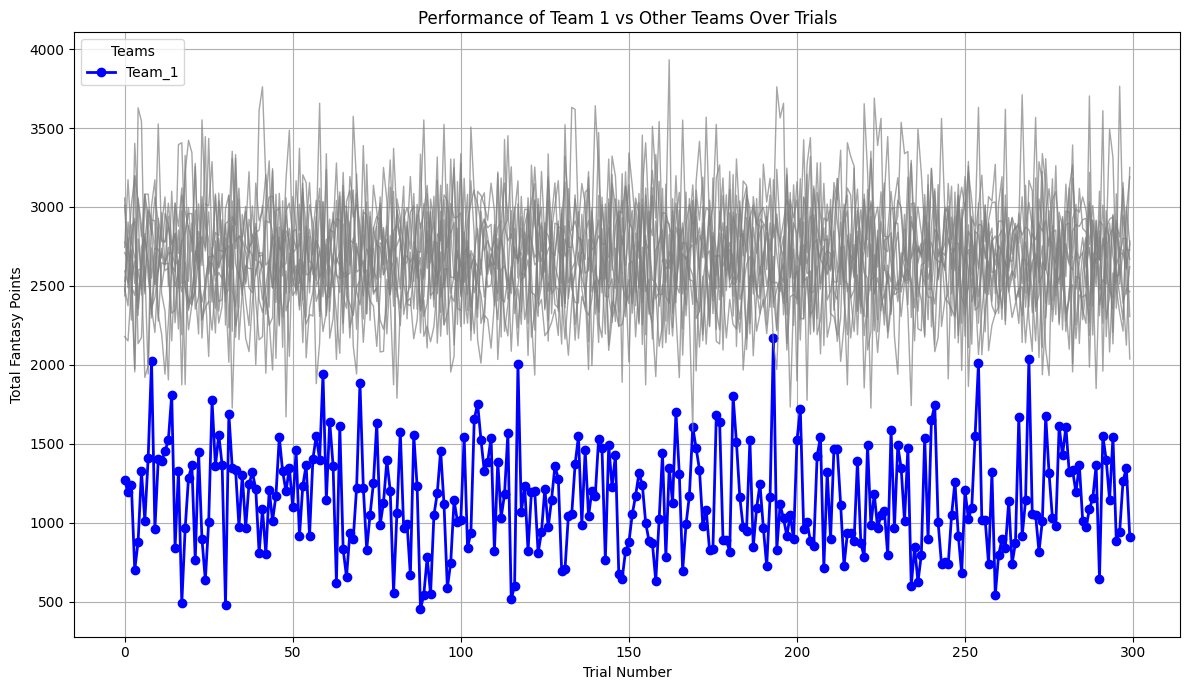

In [27]:
import matplotlib.pyplot as plt
df = results.copy()

# Group by trial and team, calculate total fantasy points
team_performance = df.groupby(['trial', 'team'])['fpts'].sum().reset_index()

# Pivot data for easier plotting (trials as rows, teams as columns)
pivot_df = team_performance.pivot(index='trial', columns='team', values='fpts')

# Plot the results
plt.figure(figsize=(12, 7))

# Plot all teams with the same gray color, except Team_1
for team in pivot_df.columns:
    if team == "Team_1":
        plt.plot(pivot_df.index, pivot_df[team], marker='o', linestyle='-', color='blue', linewidth=2, label=team)
    else:
        plt.plot(pivot_df.index, pivot_df[team], color='gray', alpha=0.7, linewidth=1)

# Add labels, title, and legend
plt.xlabel('Trial Number')
plt.ylabel('Total Fantasy Points')
plt.title('Performance of Team 1 vs Other Teams Over Trials')
plt.legend(title='Teams', loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
team 2 - 12. Rule.